In [1]:
import rasterio
import geopandas as gpd
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
from shapely.geometry import box

from tqdm import tqdm

In [2]:
os.chdir(r"C:\Users\jmy67\Desktop\RS-buildings\data\landuse-CRLC")

In [22]:
# Directory containing your TIFF files
dir_path = r'CRLC-raw'
# Search for all TIFF files in the directory
search_criteria = "*.tif"

# Output file path
out_fp = r'CRLC-mosaic.tif'

province = "Guangdong"
city = "Chengdu"

In [23]:
province_path = r'C:\Users\jmy67\Desktop\RS-buildings\data\geo_bound_original\version_31_1_2023_update_unzip\2023\province'
gdf = gpd.read_file(os.path.join(province_path,"province.shp"))
province_selected = gdf[gdf["ENG_NAME"] == province].geometry.iloc[0]

In [24]:
prefecture_path = r'C:\Users\jmy67\Desktop\RS-buildings\data\geo_bound_original\version_31_1_2023_update_unzip\2023\prefecture'
gdf = gpd.read_file(os.path.join(prefecture_path,"prefecture.shp"))

In [25]:
#gdf[gdf["省级"] == "陕西省"]

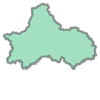

In [26]:
prefecture_selected = gdf[gdf["ENG_NAME"] == city].geometry.iloc[0]
prefecture_selected

In [27]:
obj_select = prefecture_selected
export_name = city

search_criteria = "*.tif"
query = os.path.join(dir_path, search_criteria)
tiff_files = glob.glob(query)

# Initialize list for rasters to mosaic
rasters_paths_to_mosaic = []

for tiff in tqdm(tiff_files):
    with rasterio.open(tiff) as src:
        # Create a bounding box geometry from the raster bounds
        raster_bounds = src.bounds
        raster_box = box(*raster_bounds)
        
        # Check if the raster intersects with the geometry
        if raster_box.intersects(obj_select):
            rasters_paths_to_mosaic.append(tiff)
            
if rasters_paths_to_mosaic:
    # Open all rasters to mosaic at once, to avoid the dataset closed error
    rasters_to_mosaic = [rasterio.open(tiff) for tiff in rasters_paths_to_mosaic]
    mosaic, out_trans = merge(rasters_to_mosaic)
    out_meta = rasters_to_mosaic[0].meta.copy()
    
    # Update metadata
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans,
                     "crs": rasters_to_mosaic[0].crs})
    
    # Output file path
    out_fp = f'CRLC-province/mosaic_{export_name}.tif'
    
    # Write the mosaic raster to disk
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Close all datasets
    for src in rasters_to_mosaic:
        src.close()
    

100%|██████████████████████████████████████████████████████████████████████████████| 1140/1140 [00:32<00:00, 35.28it/s]
